<a href="https://colab.research.google.com/github/elpinchepastel/Hyperspectral-Remote-Sensing-Scenes/blob/master/Salinas%20PCA%20%2B%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Hyperspectral Image Reduction**

This project is structured so:

1. Import necessary libraries

2. Download dataset Salinas (Correct and gt)

3. Review of dataset structure and loading

4. Visualizing ground truth

5. Visualizing the bands of the Correct

6. Extract pixels and class from the dataset, preparing the data for reduction

7. Dimensionality Reduction (PCA)

8. Classify by support vector machine (SVM)


## **1. Import necessary libraries**

In [1]:
%%time
!pip install spectral
!pip install tqdm

CPU times: user 21.1 ms, sys: 6.13 ms, total: 27.2 ms
Wall time: 4.14 s


In [2]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy.io
import scipy.io as sio
import seaborn as sns
import spectral

from IPython.display import Image
from matplotlib.legend_handler import HandlerLine2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tqdm import tqdm

sns.axes_style('whitegrid');

# **2. Download dataset Salinas (Correct and gt)**

In [3]:
%%time
!wget "http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat"

--2020-10-19 21:55:13--  http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26552770 (25M) [text/plain]
Saving to: ‘Salinas_corrected.mat.1’

Salinas_corrected.m 100%[===================>]  25.32M  1.85MB/s    in 14s     

2020-10-19 21:55:28 (1.78 MB/s) - ‘Salinas_corrected.mat.1’ saved [26552770/26552770]

--2020-10-19 21:55:28--  http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4277 (4.2K) [text/plain]
Saving to: ‘Salinas_gt.mat.1’

Salinas_gt.mat.1    100%[===================>]   4.18K  --.-KB/s    in 0s      

2020-10-19 21:55:28 (601 MB/s) - ‘Salinas_gt.mat.1’ saved [4277/42

In [4]:
# Verify that the ".mat" type dataset is downloaded locally
!ls

 Dataset.csv
'Salinas Correct - Band No. 10 cmap = gray.TIF'
'Salinas Correct - Band No. 10.TIF'
 Salinas_corrected.mat
 Salinas_corrected.mat.1
'Salinas Correct - First ten bands.TIF'
'Salinas Correct - Teen Band Aleatory.TIF'
'Salinas Ground Truth.TIF'
 Salinas_gt.mat
 Salinas_gt.mat.1
 sample_data
'Samples and number Salinas Ground Truth.TIF'


## **3. Review of dataset structure and loading**

In [5]:
# Data types for the dataset
correct = loadmat('Salinas_corrected.mat')
gt = loadmat('Salinas_gt.mat')
print(type(correct))
print(type(gt))

<class 'dict'>
<class 'dict'>


In [6]:
# The keys of the dictionary
print(f'Dictionary Salinas Correct: {correct.keys()}\nDictionary Salinas Ground truth: {gt.keys()}')

Dictionary Salinas Correct: dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
Dictionary Salinas Ground truth: dict_keys(['__header__', '__version__', '__globals__', 'salinas_gt'])


In [7]:
# Read the dataset
def dataset(correct, gt):
  dataset_correct = scipy.io.loadmat('Salinas_corrected.mat')['salinas_corrected']
  dataset_gt = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']
  return dataset_correct, dataset_gt

In [8]:
dataset_correct, dataset_gt = dataset(correct, gt)
print(f'Correct: {dataset_correct.shape}\nGround Truth: {dataset_gt.shape}')

Correct: (512, 217, 204)
Ground Truth: (512, 217)


In [9]:
print(type(dataset_correct))
print(type(dataset_gt))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
dict_category = {}
for i in range(dataset_gt.shape[0]):
    for j in range(dataset_gt.shape[1]):
         if dataset_gt[i][j] in [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
            if dataset_gt[i][j] not in dict_category:
                dict_category[dataset_gt[i][j]]=0
            dict_category[dataset_gt[i][j]] +=1
            
sortedDict = sorted(dict_category.items())
print(sortedDict)

[(0, 56975), (1, 2009), (2, 3726), (3, 1976), (4, 1394), (5, 2678), (6, 3959), (7, 3579), (8, 11271), (9, 6203), (10, 3278), (11, 1068), (12, 1927), (13, 916), (14, 1070), (15, 7268), (16, 1807)]


## **4. Visualizing ground truth**

In [11]:
# Colors and names for each category in the dataset
def colors_names():
  gt_color = np.array([
                      [255,   255,    255], #Backgroud
                      [0,     0,      255], #Brocoli_green_weeds_1
                      [0,     64,     255], #Brocoli_green_weeds_2
                      [0,     128,    255], #Fallow
                      [0,     191,    255], #Fallow_rough_plow
                      [0,     255,    255], #Fallow_smooth
                      [0  ,   255,    191], #Stubble
                      [64,    255,    191], #Celery
                      [128,   255,    128], #Grapes_untrained
                      [191,   255,    64],  #Soil_vinyard_develop
                      [255,   255,    0],   #Corn_senesced_green_weeds
                      [255,   191,    0],   #Lettuce_romaine_4wk
                      [255,   128,    0],   #Lettuce_romaine_5wk
                      [255,   64,     0],   #Lettuce_romaine_6wk
                      [255,   0,      0],   #Lettuce_romaine_7wk
                      [191,   0,      0],   #Vinyard_untrained
                      [128,   0,      0],   #Vinyard_vertical_trellis
                       ])
  salinas_class_names = [
                            'Background',
                            'Brocoli_green_weeds_1',
                            'Brocoli_green_weeds_2',
                            'Fallow',
                            'Fallow_rough_plow',
                            'Fallow_smooth',
                            'Stubble',
                            'Celery',
                            'Grapes_untrained',
                            'Soil_vinyard_develop',
                            'Corn_senesced_green_weeds',
                            'Lettuce_romaine_4wk',
                            'Lettuce_romaine_5wk',
                            'Lettuce_romaine_6wk',
                            'Lettuce_romaine_7wk',
                            'Vinyard_untrained',
                            'Vinyard_vertical_trellis'
                            ]
  gt_color_eventplot = gt_color/255
  return gt_color, gt_color_eventplot, salinas_class_names

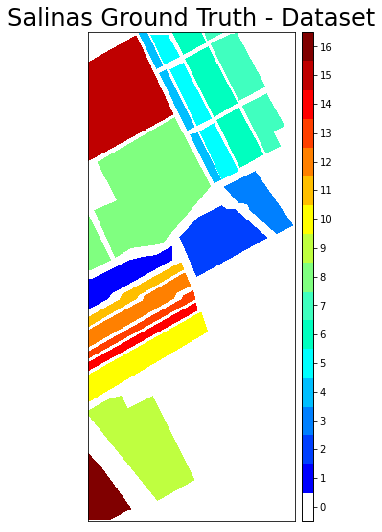

In [12]:
# Display of the "Ground truth" image
gt_color, gt_color_eventplot, salinas_class_names = colors_names()
ground_truth = spectral.imshow(classes = dataset_gt.astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.title('Salinas Ground Truth - Dataset', fontsize=24)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(cax=cax)
plt.colorbar(ticks= range(0,17), cax=cax)
plt.savefig('Salinas Ground Truth.TIF')

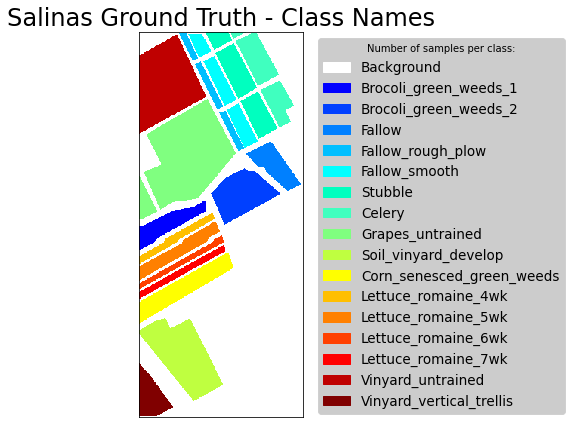

In [13]:
ground_truth = spectral.imshow(classes = dataset_gt.astype(int), figsize =(6,9),colors=gt_color, interpolation='nearest')
plt.title('Salinas Ground Truth - Class Names', fontsize=24)
patches = [mpatches.Patch(color=gt_color_eventplot[i], label=salinas_class_names[i]) for i in range(len(gt_color_eventplot))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc='upper left', facecolor='silver', fontsize=13.5, title="Number of samples per class:")
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.savefig('Samples and number Salinas Ground Truth.TIF')

## **5. Visualizing the bands of the Hyperspectral Correct**

Enter the band number of the image you want to view (The number to be between 0 and 203): 
10


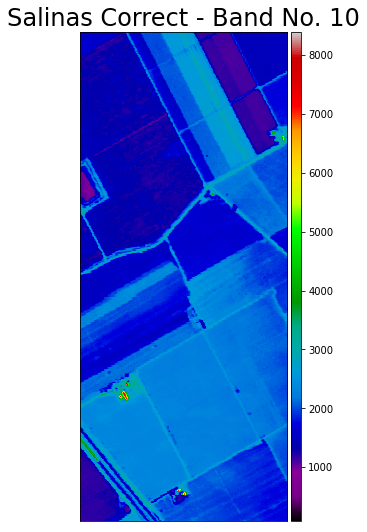

In [14]:
# Display of the "Correct" image on one band

print('Enter the band number of the image you want to view (The number to be between 0 and 203): ')
band = int(input())
one_band = dataset_correct[:, :, band]
plt.figure(figsize=(9, 9))
plt.imshow(one_band, cmap = "nipy_spectral")
plt.title(f'Salinas Correct - Band No. {band}', fontsize=24)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.savefig(f'Salinas Correct - Band No. {band}.TIF')

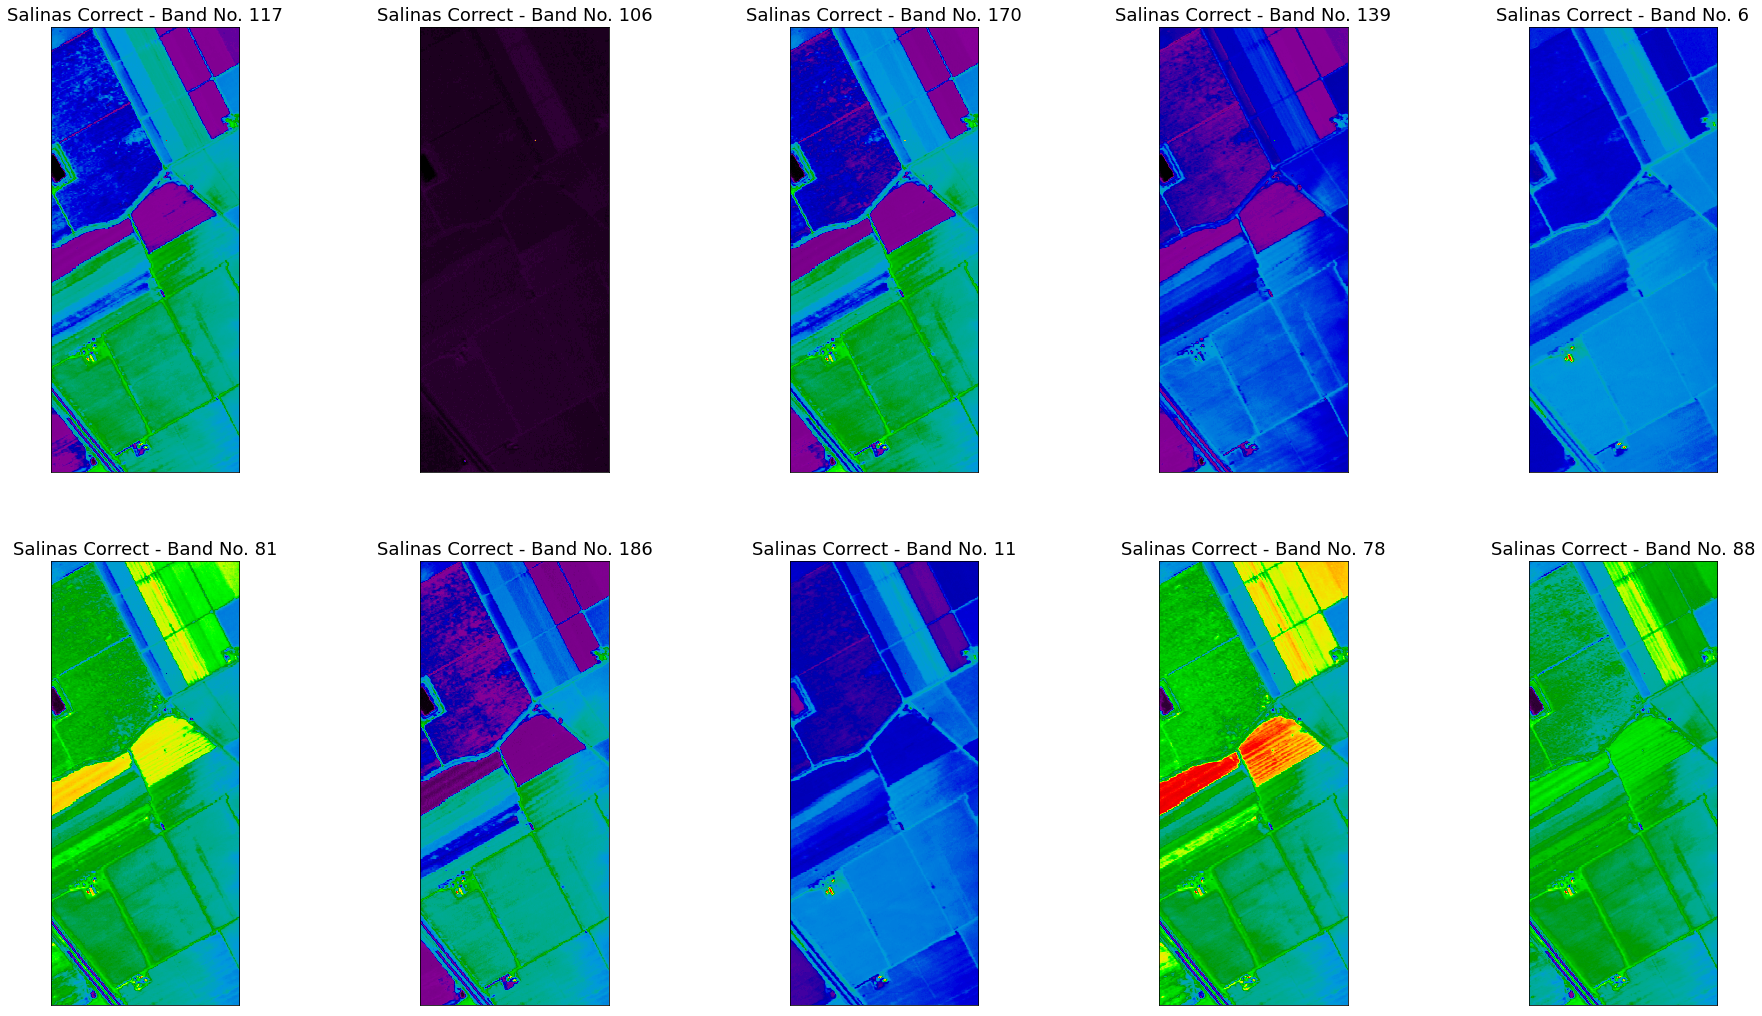

In [15]:
# Display of the "Correct" image on one band random
fig=plt.figure(figsize=(32, 18))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    band_aleatory = random.randrange(199)
    one_band = dataset_correct[:, :, band_aleatory]
    plt.imshow(one_band, cmap = "nipy_spectral")
    plt.title(f'Salinas Correct - Band No. {band_aleatory}', fontsize=18)
    plt.xticks([])
    plt.yticks([])
plt.savefig('Salinas Correct - Teen Band Aleatory.TIF')

## **6.  Extract pixels and class from the dataset, preparing the data for reduction**

In [16]:
# Extract pixels and class labels from hyperspectral image correct
def extract_pixels(dataset_correct, dataset_gt):
    df = pd.DataFrame()
    for i in tqdm(range(dataset_correct.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset_correct[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(dataset_gt.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset_correct.shape[2])]+['class']
    return df
df = extract_pixels(dataset_correct, dataset_gt)

100%|██████████| 204/204 [00:04<00:00, 50.62it/s]


In [17]:
# Print and save data
df.to_csv('Dataset.csv', index=False)
df.head()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,band-11,band-12,band-13,band-14,band-15,band-16,band-17,band-18,band-19,band-20,band-21,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,band-31,band-32,band-33,band-34,band-35,band-36,band-37,band-38,band-39,band-40,...,band-166,band-167,band-168,band-169,band-170,band-171,band-172,band-173,band-174,band-175,band-176,band-177,band-178,band-179,band-180,band-181,band-182,band-183,band-184,band-185,band-186,band-187,band-188,band-189,band-190,band-191,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,band-201,band-202,band-203,band-204,class
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,1656,1670,1584,1643,1659,1619,1723,1785,1805,1822,1809,1790,1786,1770,1779,1737,1706,1709,1699,1663,1702,1682,1715,1682,1603,1615,1746,1784,1607,1757,...,424,429,437,409,391,378,364,354,329,340,344,337,321,310,291,284,272,254,240,250,216,220,192,162,173,149,134,129,138,104,96,109,93,54,79,54,36,11,17,0
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,1656,1670,1594,1613,1649,1619,1706,1767,1796,1805,1785,1798,1786,1770,1787,1745,1714,1741,1722,1656,1734,1722,1731,1728,1611,1623,1746,1777,1593,1724,...,429,440,439,409,389,382,370,360,331,342,347,340,323,305,298,282,275,254,240,248,211,225,192,162,180,147,136,131,138,111,94,111,96,56,83,56,36,11,15,0
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,1632,1636,1573,1613,1619,1591,1670,1704,1734,1763,1744,1748,1726,1721,1732,1698,1674,1701,1675,1610,1694,1682,1666,1651,1566,1565,1704,1735,1540,1691,...,417,422,420,395,377,368,358,351,324,332,335,325,318,302,283,276,265,251,240,236,223,216,188,162,176,142,125,129,129,106,88,107,89,54,81,54,30,11,11,0
3,290,381,585,999,1316,1374,1280,1380,1584,1631,1596,1603,1531,1562,1580,1526,1617,1668,1707,1704,1703,1698,1675,1680,1677,1651,1609,1620,1605,1571,1615,1609,1601,1604,1513,1499,1647,1660,1486,1620,...,401,408,411,387,365,361,346,339,310,316,325,318,304,285,276,267,260,239,223,234,201,209,176,161,164,136,127,123,131,100,86,105,85,56,75,50,30,11,19,0
4,219,381,585,999,1286,1352,1261,1396,1555,1618,1596,1558,1489,1532,1531,1508,1599,1632,1672,1687,1662,1664,1658,1639,1645,1612,1585,1596,1589,1525,1583,1569,1568,1566,1468,1478,1605,1612,1446,1574,...,394,410,397,376,356,351,340,332,303,318,321,315,297,287,271,265,246,230,216,226,194,202,178,150,167,127,125,120,122,96,83,105,83,48,75,50,24,9,17,0


In [18]:
# Verify the save data locally
!ls

 Dataset.csv
'Salinas Correct - Band No. 10 cmap = gray.TIF'
'Salinas Correct - Band No. 10.TIF'
 Salinas_corrected.mat
 Salinas_corrected.mat.1
'Salinas Correct - First ten bands.TIF'
'Salinas Correct - Teen Band Aleatory.TIF'
'Salinas Ground Truth.TIF'
 Salinas_gt.mat
 Salinas_gt.mat.1
 sample_data
'Samples and number Salinas Ground Truth.TIF'


In [19]:
# Indexation of 145 x 145 of the first two components
def indexation(dataset_correct, dataset_gt):
  dataset_correct = df.iloc[:, :-1].values
  dataset_gt = df.iloc[:, -1].values
  return dataset_correct, dataset_gt

In [20]:
dataset_correct, dataset_gt = indexation(dataset_correct, dataset_gt)
print(f'Size Salinas Correct: {dataset_correct.shape}\nSize Salinas Ground truth: {dataset_gt.shape}')

Size Salinas Correct: (111104, 204)
Size Salinas Ground truth: (111104,)


## **7. Dimensionality Reduction (PCA)**

In [21]:
def method_PCA(n_components):
  pca = PCA(n_components = n_components)
  principalComponents = pca.fit_transform(dataset_correct)
  return principalComponents

In [22]:
print("Enter the band number of the image you want to reduce (the number must be less than 203): ")
n_components = int(input())
principalComponents = method_PCA(n_components)
print(f"Size Salinas Correct Reduced: {principalComponents.shape}")

Enter the band number of the image you want to reduce (the number must be less than 203): 
150
Size Salinas Correct Reduced: (111104, 150)


In [23]:
#Reversal of Indexing
dataset_correct_reduced = np.reshape(principalComponents, (512, 217, n_components))
print(f"Size Salinas Correct Reduced: {dataset_correct_reduced.shape}")

Size Salinas Correct Reduced: (512, 217, 150)


Enter the band number of the image you want to view (The number to be between 0 and 150): 
10


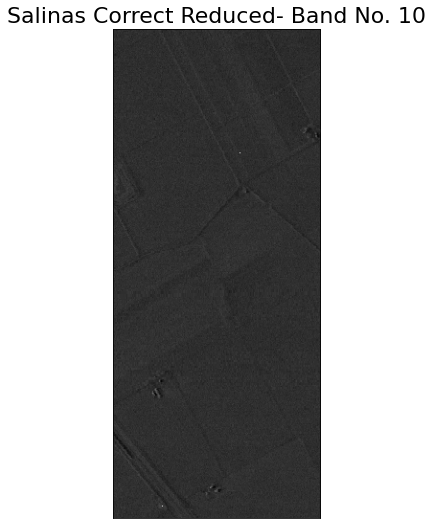

In [24]:
# Display of the "Correct" image on one band
print(f'Enter the band number of the image you want to view (The number to be between 0 and {n_components}): ')
band = int(input())
one_band = dataset_correct_reduced[:, :, band]
plt.figure(figsize=(9, 9))
plt.imshow(one_band, cmap = "gray")
plt.title(f'Salinas Correct Reduced- Band No. {band}', fontsize=22)
plt.xticks([])
plt.yticks([])
plt.savefig(f'Salinas Correct - Band No. {band} cmap = gray.TIF')

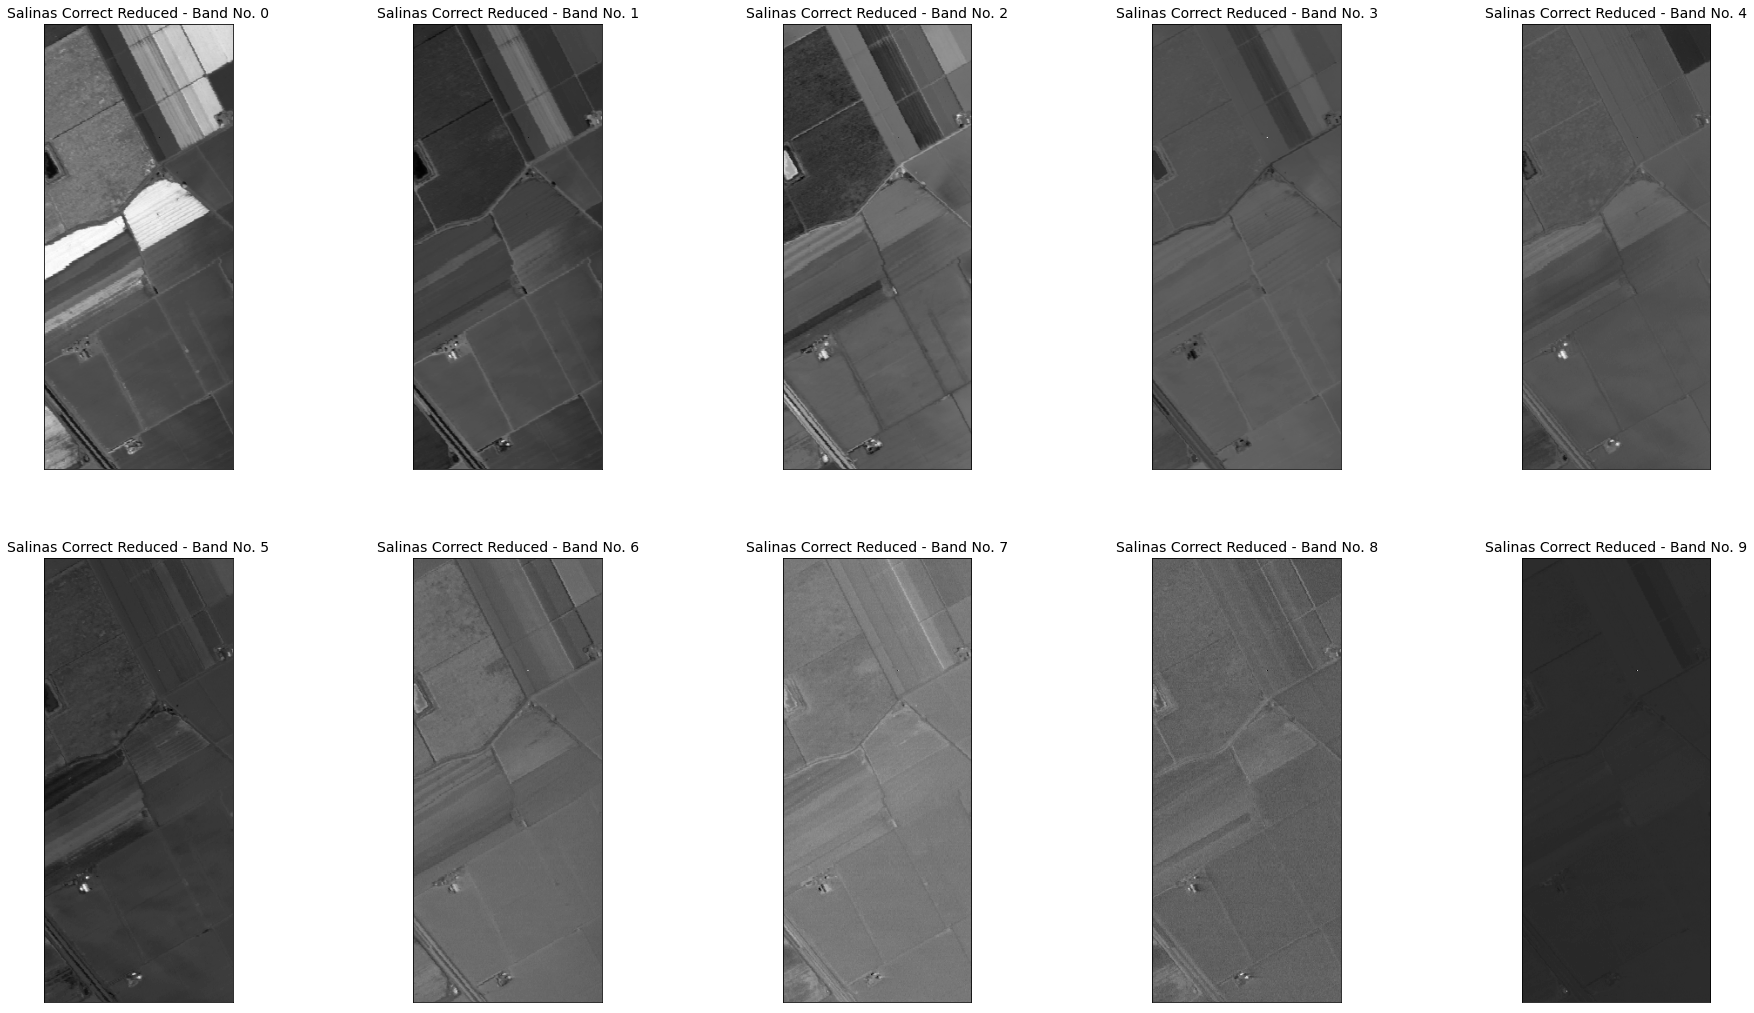

In [25]:
# Displaying the "Reduced Correct" image in the first ten bands
fig=plt.figure(figsize=(32, 18))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    I = i-1
    one_band = dataset_correct_reduced[:, :, I]
    plt.imshow(one_band, cmap = "gray")
    plt.title(f'Salinas Correct Reduced - Band No. {I}', fontsize=14)
    plt.xticks([])
    plt.yticks([])
plt.savefig(f'Salinas Correct - First ten bands.TIF')

## **8. Classify by support vector machine (SVM)**

In [26]:
# Split the reduced data through training and testing
dataset_correct_train, dataset_correct_test, dataset_gt_train, dataset_gt_test, indices_train, indices_test  = train_test_split(principalComponents, dataset_gt,  range(dataset_correct.shape[0]), 
                                                                                  test_size = 0.20, random_state = 11)

print(f'Dataset Correct Train: {dataset_correct_train.shape}\nDataset Correct Test: {dataset_correct_test.shape}')

Dataset Correct Train: (88883, 150)
Dataset Correct Test: (22221, 150)


In [27]:
def classifier(k):
  if k == "1":
    k = "rbf"
  else:
    if k == "2":
      k = "linear"
    else:
      if k == "3":
        k = "poly"
      else:
        if k == "4":
          k = "sigmoid"
        else:
          print("Select the correct option:")
  return k

In [28]:
# Select a classifier
k = input("Enter a classifier:\nrbf = 1\nlinear = 2\npoly = 3\nsigmoid = 4\n")

Enter a classifier:
rbf = 1
linear = 2
poly = 3
sigmoid = 4
1


In [29]:
# Implementing support vector machine (SVM) using a classifier
%%time
k = classifier(k)
svm = SVC(kernel=k, degree = 10, gamma='scale', cache_size=1024*7)
svm.fit(dataset_correct_train, dataset_gt_train)

CPU times: user 11min, sys: 1.36 s, total: 11min 1s
Wall time: 11min 2s


In [30]:
# Gt prediction implementation
dataset_gt_pred = svm.predict(dataset_correct_test)
pre = dataset_gt_pred

clmap = [0]*dataset_correct.shape[0]

for i in tqdm(range(len(indices_train))):
    clmap[indices_train[i]] = dataset_gt[indices_train[i]]

for i in tqdm(range(len(indices_test))):
    clmap[indices_test[i]] = pre[i]

100%|██████████| 22221/22221 [00:00<00:00, 1609672.19it/s]


In [31]:
print(f'Accuracy: {accuracy_score(dataset_gt_test,dataset_gt_pred)*100}%')

Accuracy: 85.13118221502182%


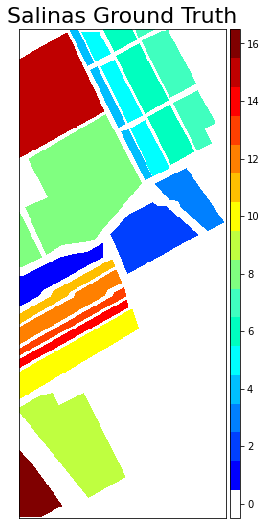

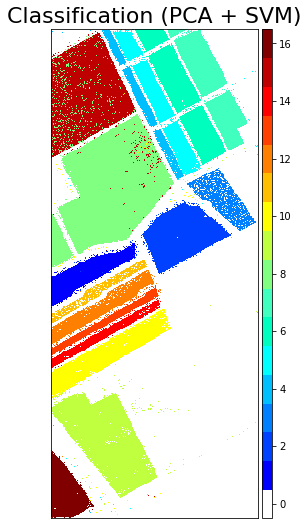

In [32]:
# Displaying the "Salinas Ground Truth" and "Salinas PCA + SVM"
gt_color, gt_color_eventplot, salinas_class_names = colors_names()
dataset_correct, dataset_gt = dataset(correct, gt)
dataset_gt = spectral.imshow(classes = dataset_gt.astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Salinas Ground Truth', fontsize=22)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)

dataset_gt_svm = spectral.imshow(classes = np.array(clmap).reshape((512, 217)).astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Classification (PCA + SVM)', fontsize=22)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)

plt.savefig('Classification (PCA + SVM).TIF')

In [33]:
print('Classification report:\n',classification_report(dataset_gt_test,dataset_gt_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89     11445
           1       0.83      0.98      0.90       421
           2       0.82      0.99      0.90       695
           3       0.00      0.00      0.00       375
           4       0.82      0.79      0.80       267
           5       0.77      0.94      0.85       536
           6       0.88      0.98      0.92       816
           7       0.89      0.99      0.94       691
           8       0.73      0.90      0.81      2281
           9       0.86      0.90      0.88      1243
          10       0.83      0.81      0.82       651
          11       0.00      0.00      0.00       222
          12       0.81      0.73      0.77       388
          13       0.70      0.97      0.82       191
          14       0.69      0.82      0.75       208
          15       0.79      0.52      0.63      1425
          16       0.94      0.96      0.95       366

  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


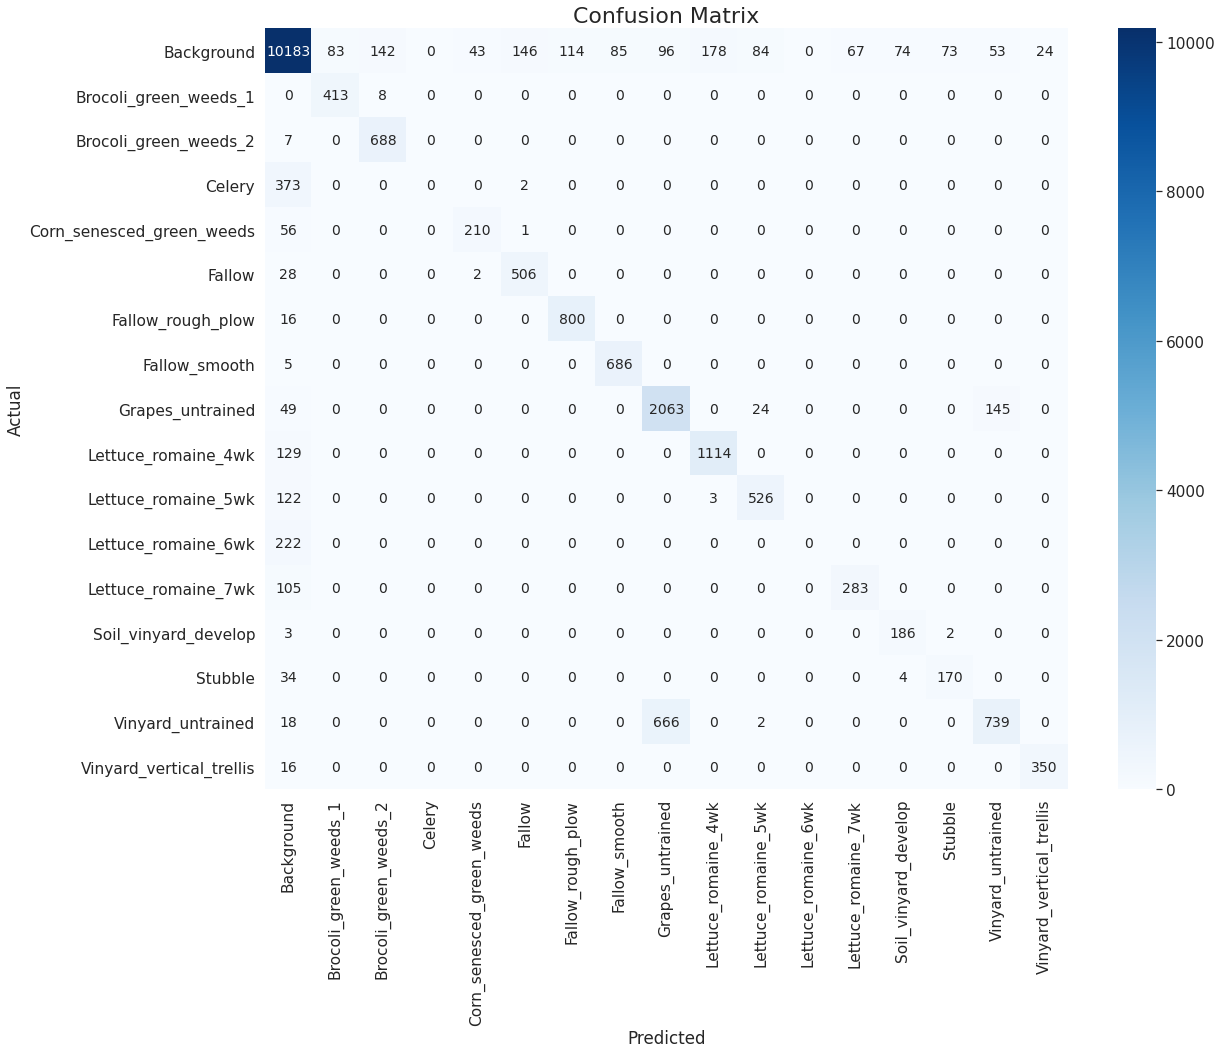

In [34]:
gt_color, gt_color_eventplot, salinas_class_names = colors_names()
data = confusion_matrix(dataset_gt_test, dataset_gt_pred)
df_cm = pd.DataFrame(data, columns=np.unique(salinas_class_names), index = np.unique(salinas_class_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (18,14))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 14}, fmt='d')
plt.title('Confusion Matrix', fontsize=22)
plt.savefig('Confusion Matrix.TIF')